# Classifying Cookies from Non-Cookies
Combine the existing chocolate chip cookie dataset with xxx.

In [1]:
import os

cookie_images_dir = os.path.join('./dataset/images')

Build a custom cookie/non-cookie dataset. Combines the cookie images with CIFAR-10 - a Keras dataset with 10 categories and 50,000 images.

In [2]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_bin_class_dataset(cookie_images_dir, num_non_cookie_samples=1000, target_size=(224, 224)):
    """
    Create a binary classification dataset of cookies vs non-cookies
    
    Parameters:
    cookie_dir: Path to directory containing cookie images
    num_non_cookie_samples: Number of non-cookie images to include
    target_size: Target size for all images
    
    Returns:
    (x_train, y_train), (x_test, y_test): Training and test datasets
    """
    
    # Load and preprocess cookie images
    cookie_images_path = pathlib.Path(cookie_images_dir)
    cookie_images = list(cookie_images_path.glob('*.[jJ][pP][gG]')) + list(cookie_images_path.glob('*.[pP][nN][gG]'))
    
    # Load and preprocess cookie images
    cookies = []
    for img_path in cookie_images:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        cookies.append(img_array)
    
    cookies = np.array(cookies)
    
    # Load CIFAR-10 as source of non-cookie images
    (cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Resize CIFAR images to match cookie image size
    non_cookies = []
    for img in cifar_x_train[:num_non_cookie_samples]:
        resized = tf.image.resize(img, target_size)
        non_cookies.append(resized)
    
    non_cookies = np.array(non_cookies)
    
    # Combine datasets
    X = np.concatenate([cookies, non_cookies])
    y = np.concatenate([np.ones(len(cookies)), np.zeros(len(non_cookies))])
    
    # Shuffle the dataset
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Split into train and test sets
    split = int(0.8 * len(X))
    x_train, x_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Normalize pixel values
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    return (x_train, y_train), (x_test, y_test)

# Data augmentation for training
def create_data_generators(x_train, y_train, x_test, y_test, batch_size=32):
    """
    Create data generators with augmentation for training
    """
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow(
        x_train, y_train,
        batch_size=batch_size
    )
    
    test_generator = test_datagen.flow(
        x_test, y_test,
        batch_size=batch_size
    )
    
    return train_generator, test_generator

2025-01-01 21:11:47.248131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the dataset and create generators.

In [3]:
# Load and prepare the dataset
(x_train, y_train), (x_test, y_test) = create_bin_class_dataset(cookie_images_dir)

# Create data generators
train_generator, test_generator = create_data_generators(x_train, y_train, x_test, y_test)

# Print dataset info
print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")

Training samples: 849
Test samples: 213


## Build a model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_cookie_classifier(input_shape=(224, 224, 3)):
    """
    Build a CNN model for cookie classification
    
    Parameters:
    input_shape: Shape of input images (height, width, channels)
    
    Returns:
    model: Compiled Keras model
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

## Train the model

In [5]:

def train_model(model, train_generator, test_generator, epochs=50):
    """
    Train the model with callbacks for early stopping and learning rate reduction
    
    Parameters:
    model: Compiled Keras model
    train_generator: Training data generator
    test_generator: Validation data generator
    epochs: Maximum number of epochs to train
    
    Returns:
    history: Training history
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history

def plot_training_history(history):
    """
    Plot training history including accuracy and loss curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

You can start training for 10 epochs -- this may take a few minutes to run. Increasing the number of epochs reduces the model loss.

| Epochs           | Accuracy    | Loss    |
|------------------|-------------|---------|
| 20               | 0.9999      | 0.0091  |


/Users/svend/.pyenv/versions/3.12.7/envs/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,672,097 (197.11 MB)

 Trainable params: 51,670,177 (197.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.6205 - auc_1: 0.7886 - loss: 0.8972 - val_accuracy: 0.9577 - val_auc_1: 0.2808 - val_loss: 0.2161 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.8305 - auc_1: 0.9946 - loss: 0.4465 - val_accuracy: 0.9014 - val_auc_1: 0.0387 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.9461 - auc_1: 0.9989 - loss: 0.2040 - val_accuracy: 0.9577 - val_auc_1: 0.3186 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.9585 - auc_1: 0.9996 - loss: 0.1495 - val_accuracy: 0.9577 - val_auc_1: 0.1879 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.9842 - auc_1: 0.9984 - loss: 0.0913 - val_accuracy: 0.9577 - val_auc_1: 0.6068 - val_loss: 0.1804 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step - accuracy: 0.

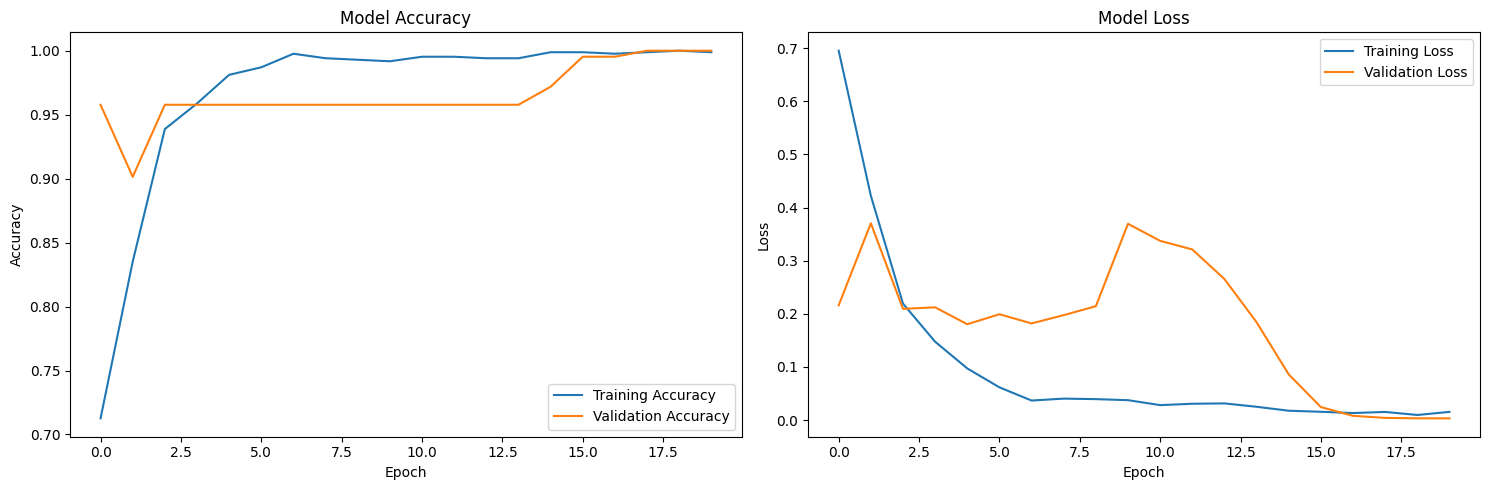

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 840ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0035

Test Accuracy: 1.0000
Test AUC: 1.0000


In [15]:
# Build and compile the model
model = build_cookie_classifier()

# Print model summary
model.summary()

# Train the model
history = train_model(model, train_generator, test_generator, epochs=20)

# Plot training history
plot_training_history(history)

# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

## Predict images

In [16]:
def predict_image(model, image_path, target_size=(224, 224)):
    """
    Make a prediction on a single image
    
    Parameters:
    model: Trained Keras model
    image_path: Path to the image file
    target_size: Size to resize the image to (should match model's input size)
    
    Returns:
    prediction: Probability of the image being a cookie
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    # Display the image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {"Cookie" if prediction >= 0.5 else "Not Cookie"}\nProbability: {prediction:.2%}')
    plt.show()
    
    return prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


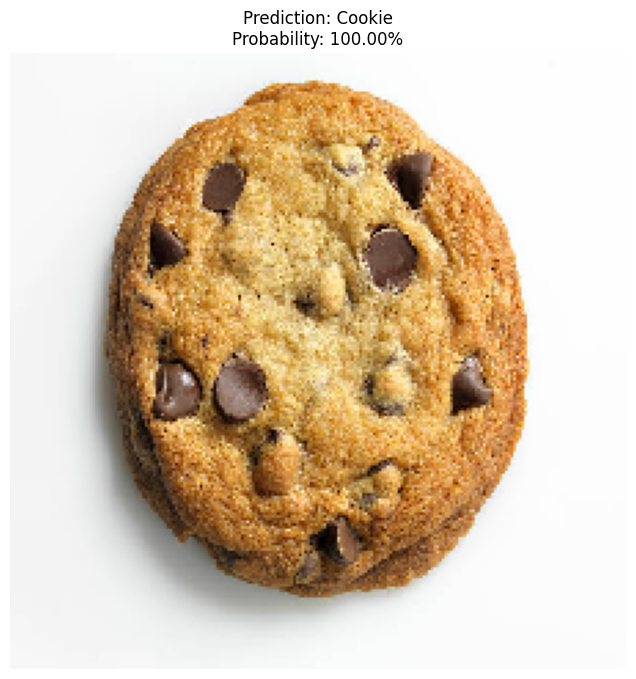


Prediction probability: 1.0000
Class: Cookie


In [17]:
# Make prediction on new image
prediction = predict_image(model, "./prediction.jpg")
print(f"\nPrediction probability: {prediction:.4f}")
print(f"Class: {'Cookie' if prediction >= 0.5 else 'Not Cookie'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


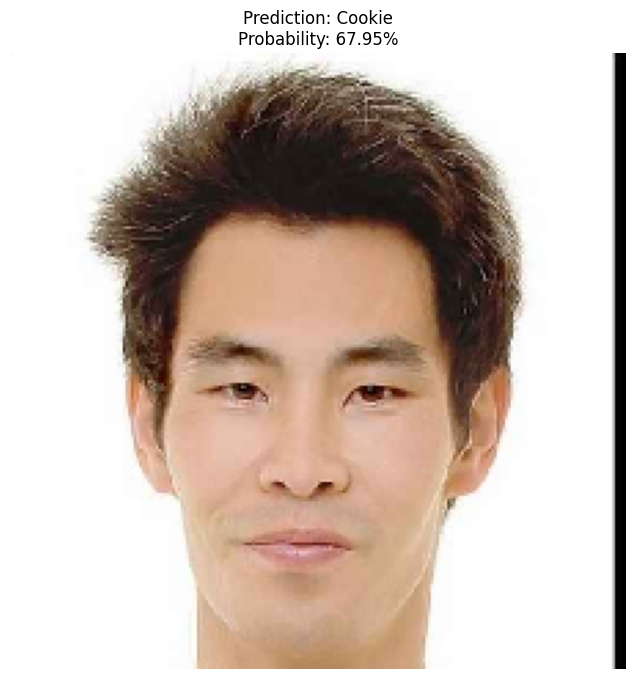


Prediction probability: 0.6795
Class: Cookie


In [18]:
# Make prediction on new image
prediction = predict_image(model, "./non-cookie 1.jpg")
print(f"\nPrediction probability: {prediction:.4f}")
print(f"Class: {'Cookie' if prediction >= 0.5 else 'Not Cookie'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


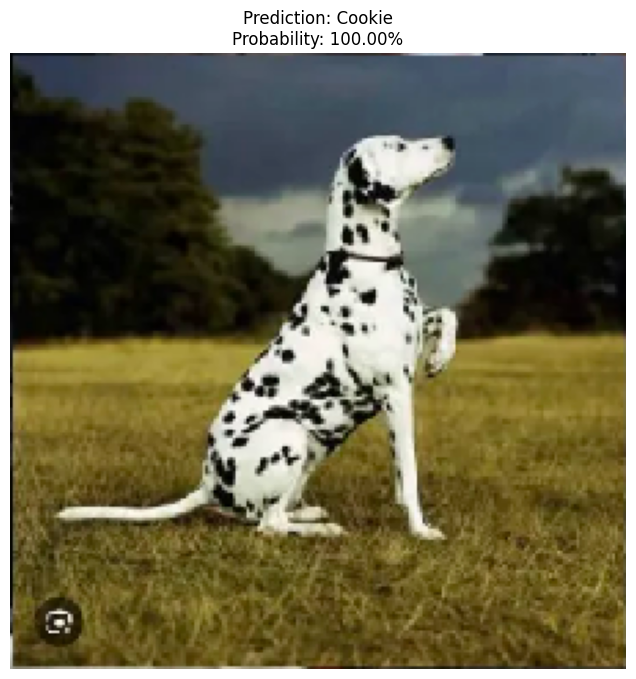


Prediction probability: 1.0000
Class: Cookie


In [19]:
# Make prediction on new image
prediction = predict_image(model, "./non-cookie 2.png")
print(f"\nPrediction probability: {prediction:.4f}")
print(f"Class: {'Cookie' if prediction >= 0.5 else 'Not Cookie'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


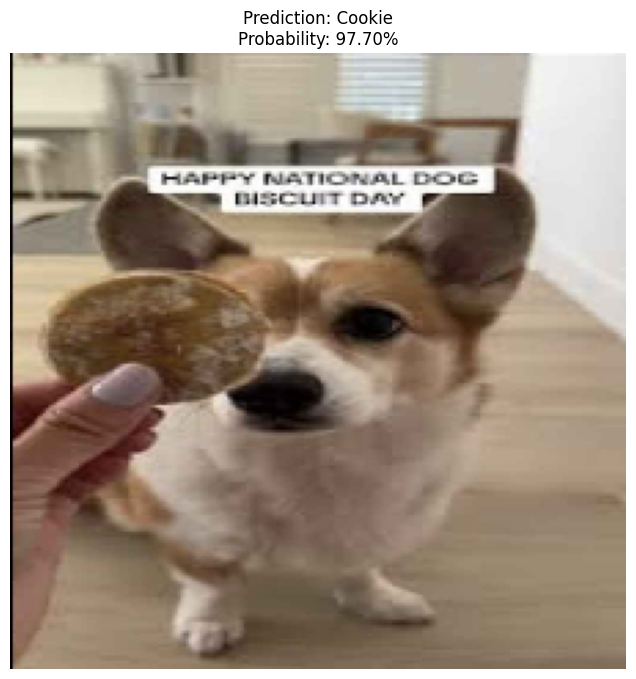


Prediction probability: 0.9770
Class: Cookie


In [20]:
# Make prediction on new image
prediction = predict_image(model, "./non-cookie 3.jpg")
print(f"\nPrediction probability: {prediction:.4f}")
print(f"Class: {'Cookie' if prediction >= 0.5 else 'Not Cookie'}")